In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from tqdm import tqdm
import os

In [2]:
#using SQLite Table to read data.
con = sqlite3.connect("C:/Users/parth/Downloads/Amazon Fine Food Review/database.sqlite") 

In [3]:
type(con)

sqlite3.Connection

In [4]:
#reading the sql data through pandas query function
df = pd.read_sql_query('Select * From Reviews LIMIT 5000', con)


In [5]:
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [6]:
df.shape

(5000, 10)

Sentiment Analysis

In [7]:
from textblob import TextBlob

In [8]:
text = df['Summary'][0]
text

'Good Quality Dog Food'

In [9]:
TextBlob(text).sentiment.polarity

0.7

In [10]:
#making a list of polarity of the summary reviews
polarity = []
for i in df["Summary"]:
    try:
        polarity.append(TextBlob(i).sentiment.polarity)
    except:
        polarity.append(0)

In [11]:
print(len(polarity))
df.shape

5000


(5000, 10)

In [12]:
#Taking copy of the dataframe
data = df.copy()

In [13]:
#inserting the polarity values in the dataframe
data['Polarity'] = polarity 

In [14]:
data.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   
3         Cough Medicine  If you are looking for the secret ingredient i...   
4            Great taffy  Great taffy at a great price.  There was a wid...   

   Polarity  
0       0.7  
1       0.0  
2       0.0  
3       0.0  
4       0.8

In [15]:
type(data)

pandas.core.frame.DataFrame

In [16]:
data[['Score','Polarity']]

Score  Polarity
0         5    0.7000
1         1    0.0000
2         4    0.0000
3         2    0.0000
4         5    0.8000
...     ...       ...
4995      2    0.5000
4996      1    0.6000
4997      3    0.0500
4998      4    0.7000
4999      5    0.7125

[5000 rows x 2 columns]

In [17]:
value_counts = data['Score'].value_counts()
print(value_counts)

5    3134
4     712
1     469
3     395
2     290
Name: Score, dtype: int64


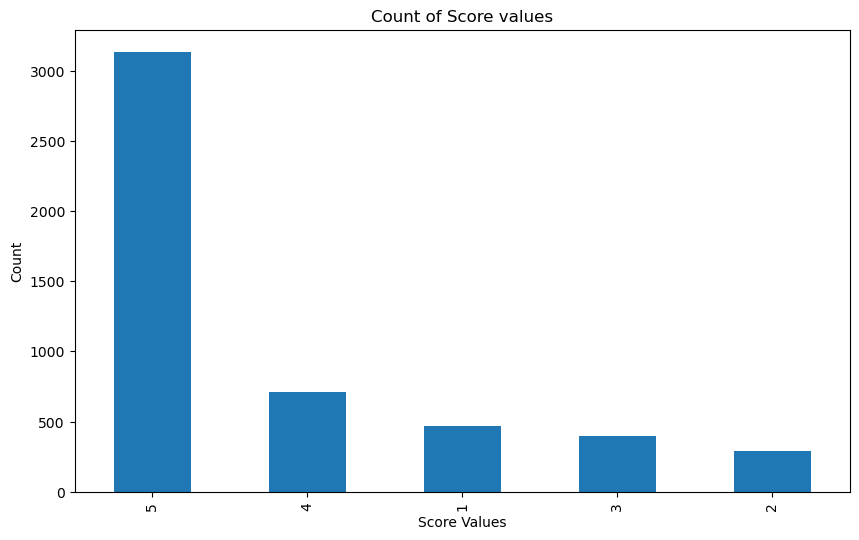

In [18]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
value_counts.plot(kind='bar')
plt.title("Count of Score values")
plt.xlabel("Score Values")
plt.ylabel("Count")
plt.show()

In [19]:
data.groupby('Score')['Polarity'].mean()

Score
1   -0.180216
2    0.021378
3    0.164028
4    0.358398
5    0.473890
Name: Polarity, dtype: float64

In [20]:
data.groupby('Score')['Polarity'].median()

Score
1    0.00
2    0.00
3    0.00
4    0.35
5    0.50
Name: Polarity, dtype: float64

# Exploratory Data Analysis

DATA CLEANING

In [21]:
#Sorting data according to ProductId in ascending order
data=data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [22]:
#Deduplication of entries
data_dd=data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
data_dd.shape

(4985, 11)

In [23]:
#Checking to see how much % of datapoints were duplicate
print(100-(data_dd['Id'].size*1.0)/(data['Id'].size*1.0)*100)

0.29999999999999716


In [24]:
#To remove rows(if any) having HelpfulnessNumerator greater than HelpfulnessDenominator 
data_dd=data_dd[data_dd.HelpfulnessNumerator<=data_dd.HelpfulnessDenominator]

Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [25]:
# printing some random reviews
sent_0 = data_dd['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = data_dd['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = data_dd['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = data_dd['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
Kettle brand chips are very crunchy.  I would say regular plain old Lays potato chips are at the "soft" end of the "soft/crunchy" spectrum.  Ruffles brand potato chips used to be considered the crunchiest, but Kettle brand chips are far more crunchy.  If you have a tender mouth or bad teeth (dentures) you might want to steer clear of Kettle brand.  Otherwise, you'll love these chips.  The Sea Salt & Vinegar chips are super TANGY.  I enjoy taking swigs of vinegar bottles from time to time.  I am dissapointed with all other Salt & Vinegar chips either because the chips are too soft and/or the vinegar taste whimpy and/or chemically.  Rest assured Kettle Sea Salt & Vinegar has a gourmet flavor.  The vinegar flavor has no chemical flavor and could NEVER be called whimpy!
tastes pretty crappy. it's like raw cookies.<br /><br />it's not even like a cookie. it's a squishy thing in a cookie shape
Carabou Mahogony is

In [26]:
# remove urls from text 
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [27]:
#Removing tags 
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
Kettle brand chips are very crunchy.  I would say regular plain old Lays potato chips are at the "soft" end of the "soft/crunchy" spectrum.  Ruffles brand potato chips used to be considered the crunchiest, but Kettle brand chips are far more crunchy.  If you have a tender mouth or bad teeth (dentures) you might want to steer clear of Kettle brand.  Otherwise, you'll love these chips.  The Sea Salt & Vinegar chips are super TANGY.  I enjoy taking swigs of vinegar bottles from time to time.  I am dissapointed with all other Salt & Vinegar chips either because the chips are too soft and/or the vinegar taste whimpy and/or chemically.  Rest assured Kettle Sea Salt & Vinegar has a gourmet flavor.  The vinegar flavor has no chemical flavor and could NEVER be called whimpy!
tastes pretty crappy. it's like raw cookies.it's not even like a cookie. it's a squishy thing in a cookie shape
Carabou Mahogony is the worst t

In [28]:
#Replacing Phrases
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

tastes pretty crappy. it is like raw cookies.<br /><br />it is not even like a cookie. it is a squishy thing in a cookie shape


In [30]:
#remove words with numbers
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [31]:
#remove special character:
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

tastes pretty crappy it is like raw cookies br br it is not even like a cookie it is a squishy thing in a cookie shape


In [32]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))   


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\parth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
sno=nltk.stem.SnowballStemmer('english')

In [34]:
# Combining all the above steps 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(data_dd['Text'].values): 
    sentence = re.sub(r"http\S+", "", sentence)                                        #Remove urls from text 
    sentence = BeautifulSoup(sentence, 'lxml').get_text()                              #Removing tags 
    sentence = decontracted(sentence)                                                  #Replacing Phrases
    sentence = re.sub("\S*\d\S*", "", sentence).strip()                                #Remove words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)                                     #Remove special character
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stop)  # we are removing the words from the stop words list
    sentence=(sno.stem(sentence.lower())).encode('utf8')                               #Stemming 
    preprocessed_reviews.append(sentence.strip())

100%|██████████| 4985/4985 [00:01<00:00, 2867.76it/s]


In [35]:
preprocessed_reviews[1500]

b'tastes pretty crappy like raw cookies even like cookie squishy thing cookie shap'

In [36]:
#Adding the cleantext column into data and removing text column
data_dd["cleantext"]=preprocessed_reviews
data_dd.drop(columns=["Text"],inplace=True)
data_dd.head()

Id   ProductId          UserId                  ProfileName  \
2774  2775  B00002NCJC  A13RRPGE79XFFH                     reader48   
2773  2774  B00002NCJC  A196AJHU9EASJN                 Alex Chaffee   
1243  1244  B00002Z754  A3B8RCEI0FXFI6                    B G Chase   
1244  1245  B00002Z754  A29Z5PI9BW2PU3                       Robbie   
3202  3203  B000084DVR  A3DKGXWUEP1AI2  Glenna E. Bauer "Puppy Mum"   

      HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
2774                     0                       0      5  1281052800   
2773                     0                       0      4  1282953600   
1243                    10                      10      5   962236800   
1244                     7                       7      5   961718400   
3202                     3                       3      5  1163030400   

                             Summary  Polarity  \
2774                    Flies Begone     0.000   
2773                   thirty bucks?     0.000   
1243  WOW Make your own 'slickers' !     0.425   
1244                   Great Product     0.800   
3202     Premium Quality Dog Food!!!     0.000   

                                              cleantext  
2774  b'used victor fly bait seasons ca beat great p...  
2773  b'product available victor traps unreal course...  
1243  b'received shipment could hardly wait try prod...  
1244  b'really good idea final product outstanding u...  
3202  b'using food months find excellent fact two do...

EDA for positive sentences                                       
The positive sentences have a polarity value > 0

In [37]:
#filtering and storing positive & negative sentences 
data_positive = data_dd[data_dd["Polarity"]>0]
data_negative = data_dd[data_dd["Polarity"]<0]

In [38]:
print(data_positive.shape)
print(data_negative.shape)

(2981, 11)
(452, 11)


In [39]:
from wordcloud import WordCloud, STOPWORDS

## Stop Words:

A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. We would not want these words to take up space in our database, or taking up valuable processing time.

In [40]:
stopwords = set(STOPWORDS)

In [41]:
#joing the summary data
total_text_p = (" ".join(data_positive['Summary']))
total_text_p[0:10000]

'WOW Make your own \'slickers\' ! Great Product Good stuff! Cats love it! Nice, Big Pieces & Big Almond Flavor A favorite quick meal solution What everyone is saying here about Pico Pica is true Pico Pica ... the BEST Best Hot Sauce and Taco Sauce Available In America gold dust is awesome Create Exquisite Cake Decorations Perfect for my sons cake. Really cute - made a great golf cake Fantastic I\'m with the crowd. Best all purpose sauce ever. Really different - Really good the ultimate sweet and sour sauce Sweet, and just down right delish! My favorite sauce at Tijuana Flats This goes great in many dishes Fantastic! Really good sauce Great Sauce!!! Really nice - sweet but with a bit of a kick Great taste! Perfect Condiment BEST SAUCE EVER! SWEEEEET......and Hot What?  All These Folks Are Right? Taste\'s Great The Best no doubt about it! Nobody Does It Better Absolutely love! Too much Just Okay, Too Sweet Great product Classic Condiment Highly Addicting! Great Sauce! great sauce My Favo

In [42]:
#joing the summary data
total_text_n = (" ".join(data_negative['Summary']))
total_text_n[0:10000]

'Little Flavor Sad outcome All By-Product & Corn -- Don\'t Waste Your Money! The worst snap-lock reseal ever made? Superlative store bought cookies: very hard to find! Awful stale cigars boring boring boring I had 3 EMPTY tea bags...BEWARE! Benefit hard to determine I was skeptical Nearly killed the cats CHANGED FORMULA MAKES CATS SICK!!!! This formula is terrible! Terrible! Tasteless mess Horrible smell Needs a little something artificial flavor a little expensive But quality seems to be slipping "Health food" from China? Doubtful Not Real Peanut Satay Wrong product Little ones like them...and NO SOY! Too thin the garbanzo beans in it give horrible gas Not Safe! Zesty spearmint and lemon are modulated by green tea into a substantial potion! Seemingly impossible... Flavor in, Calories Down, Fat Nearly Out Cookie chips were not very tasty Oreo Thin Crisps 100 Calorie Packs Oreo Thin Crisps work for me Not impressed Ultra thin wasa A Bitter Pill Oh so bitter tasting...... Poor Food Desig

## Regular Expression:

A Regular Expressions (RegEx) is a special sequence of characters that uses a search pattern to find a string or set of strings. It can detect the presence or absence of a text by matching it with a particular pattern, and also can split a pattern into one or more sub-patterns. Python provides a re module that supports the use of regex in Python. Its primary function is to offer a search, where it takes a regular expression and a string. Here, it either returns the first match or else none.

We will now replace all the characters of the total_text except "a-z" and "A-Z" by some space

In [43]:
total_text_p = re.sub('[^a-zA-Z]',' ', total_text_p)
total_text_n = re.sub('[^a-zA-Z]',' ', total_text_n)

In [44]:
total_text_p = re.sub(' +',' ',total_text_p)
total_text_n = re.sub(' +',' ',total_text_n)


In [45]:
print(len(total_text_p))
print(len(total_text_n))

73180
11192


In [46]:
type(total_text_p)

str

## WordCloud:

Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. Word clouds are widely used for analyzing data from social network websites.



(-0.5, 1999.5, 999.5, -0.5)

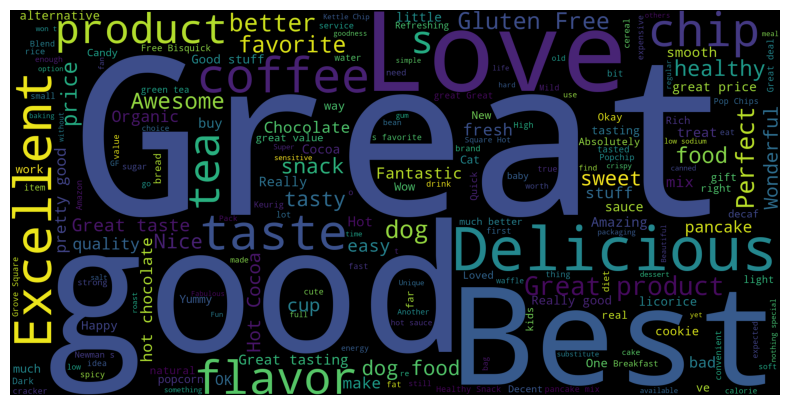

In [47]:
#forming a wordcloud using total_text
wordcloud = WordCloud(width=2000,height=1000,stopwords = stopwords,font_path=None).generate(total_text_p)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 1999.5, 999.5, -0.5)

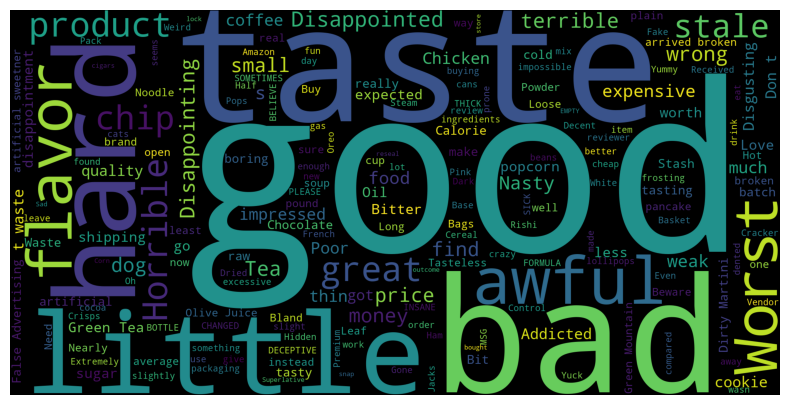

In [48]:
#forming a wordcloud using total_text
wordcloud = WordCloud(width=2000,height=1000,stopwords = stopwords,font_path=None).generate(total_text_n)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis("off")

The words 'bad','little','taste','Disappointed','Terrible','expensive','Awful','Horrible' have been used more frequently and have high significance for positive reviews.

## What customers can Amazon target?

In [49]:
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [50]:
#finding out the total number of unique buyers
df['UserId'].nunique()

4804

In order to target the customers to recommend more products or in other words to increase cobversion rate we will look for customers which have given more summaries or reviews, who have bought more number of products and who have high mean score.

These customers can be targeted and they can buy more products.

In [51]:
raw = df.groupby('UserId').agg({'Summary':'count','Text':'count','Score':'mean','ProductId':'count'}).sort_values(by='Text',ascending=False)

In [52]:
raw

Summary  Text  Score  ProductId
UserId                                         
A3OXHLG6DIBRW8        5     5    4.4          5
AY12DBB0U420B         5     5    4.4          5
A3NHUQ33CFH3VM        5     5    3.0          5
A31N6KB160O508        5     5    4.4          5
A3PJZ8TU8FDQ1K        5     5    5.0          5
...                 ...   ...    ...        ...
A29U9JOS54XZCH        1     1    5.0          1
A29TZ0192IY8IZ        1     1    5.0          1
A29SUR9R8ZU54B        1     1    5.0          1
A29SL443S0BDKQ        1     1    5.0          1
AZZ7SCDDZR0R3         1     1    5.0          1

[4804 rows x 4 columns]

In [53]:
raw.columns = ['No. of Summaries', "No. of Texts", "Average Score", "No. of Products Purchased"]
raw

No. of Summaries  No. of Texts  Average Score  \
UserId                                                          
A3OXHLG6DIBRW8                 5             5            4.4   
AY12DBB0U420B                  5             5            4.4   
A3NHUQ33CFH3VM                 5             5            3.0   
A31N6KB160O508                 5             5            4.4   
A3PJZ8TU8FDQ1K                 5             5            5.0   
...                          ...           ...            ...   
A29U9JOS54XZCH                 1             1            5.0   
A29TZ0192IY8IZ                 1             1            5.0   
A29SUR9R8ZU54B                 1             1            5.0   
A29SL443S0BDKQ                 1             1            5.0   
AZZ7SCDDZR0R3                  1             1            5.0   

                No. of Products Purchased  
UserId                                     
A3OXHLG6DIBRW8                          5  
AY12DBB0U420B                           5  
A3NHUQ33CFH3VM                          5  
A31N6KB160O508                          5  
A3PJZ8TU8FDQ1K                          5  
...                                   ...  
A29U9JOS54XZCH                          1  
A29TZ0192IY8IZ                          1  
A29SUR9R8ZU54B                          1  
A29SL443S0BDKQ                          1  
AZZ7SCDDZR0R3                           1  

[4804 rows x 4 columns]

We will now plot a bar plot for our top 10 customers we want to target.

In [54]:
top_10_customers = raw.index[0:10]
number_10 = raw['No. of Products Purchased'][0:10]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'A3OXHLG6DIBRW8'),
  Text(1, 0, 'AY12DBB0U420B'),
  Text(2, 0, 'A3NHUQ33CFH3VM'),
  Text(3, 0, 'A31N6KB160O508'),
  Text(4, 0, 'A3PJZ8TU8FDQ1K'),
  Text(5, 0, 'A3RMGIKUWGPZOK'),
  Text(6, 0, 'AR7TAEEUDHMUB'),
  Text(7, 0, 'A2R6RA8FRBS608'),
  Text(8, 0, 'A2NLZ3M0OJV9NX'),
  Text(9, 0, 'A2MUGFV2TDQ47K')])

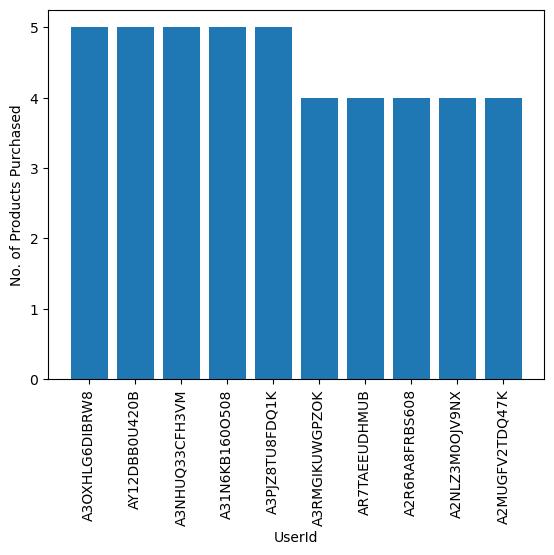

In [55]:
#plotting the barplot
plt.bar(top_10_customers, number_10);
plt.xlabel("UserId")
plt.ylabel("No. of Products Purchased")
plt.xticks(rotation = 90)

## Analyzing the Length of Comments

We will analyze the length of comments by taking a sample of data.

In [56]:
final = df[0:2000]

In [57]:
final.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [58]:
#checking for the null values in sample
final.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [59]:
#checking for duplicate values
final.duplicated().sum()

0

We see that there are no null values and no duplicate values in the final data sample.

We will now analyze the length of the customers comments:

In [60]:
def calc_len(text):
    return len(text.split(' '))

In [61]:
final["Length of Text"] = final["Text"].apply(calc_len)

In [62]:
final.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2  "Delight" says it all  This is a confection that has been around a fe...   
3         Cough Medicine  If you are looking for the secret ingredient i...   
4            Great taffy  Great taffy at a great price.  There was a wid...   

   Length of Text  
0              49  
1              31  
2              99  
3              43  
4              30

We will now analyze the distribution of the Length of text using the boxplot:

In [63]:
#plotting box plot
import plotly.express as px
px.box(final,y = 'Length of Text')

1 We observe that 50% of the users will give the review of less than 53 words approximately.

2 Only few users will give a length review

## Anlayzing Score¶

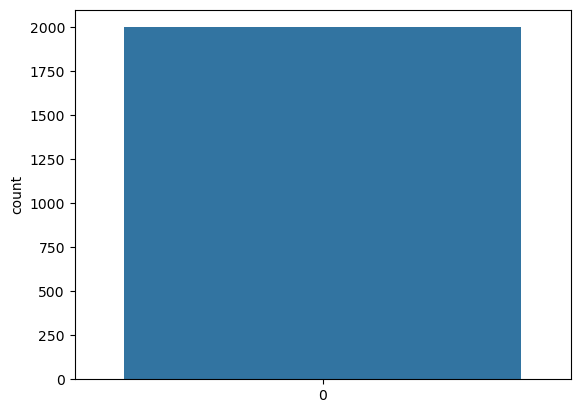

In [64]:
sns.countplot(final["Score"]);

We observe that majority of the customers give a score of 5 for the products they purchased.

## Anlayzing the behaviour of Customers¶

We will start by converting the text column in our reviews to lowercase letters in order to bring entire text into a standard format.

In [65]:
final['Text'] = final["Text"].str.lower()

We want to substitue our punctuations only now but do not want to remove numerical values. For this we can not use the re. sub functions. Hence we will implement our own logic to handle this problem.

In [66]:
import string
punctuations = string.punctuation
def remove_punctuation(review):
    no_punc=''
    for char in review:
        if char not in punctuations:
            no_punc = no_punc+char
    return no_punc

In [67]:
final["Text"] = final["Text"].apply(remove_punctuation)

In [68]:
final.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  i have bought several of the vitality canned d...   
1      Not as Advertised  product arrived labeled as jumbo salted peanut...   
2  "Delight" says it all  this is a confection that has been around a fe...   
3         Cough Medicine  if you are looking for the secret ingredient i...   
4            Great taffy  great taffy at a great price  there was a wide...   

   Length of Text  
0              49  
1              31  
2              99  
3              43  
4              30

In [69]:
final['Text'][164]

'seriously this product was as tasteless as they come there are much better tasting products out there but at 100 calories its better than a special k bar or cookie snack pack you just have to season it or combine it with something else to share the flavor'

We will remove the stopwords now from the text column using nltk library.

In [70]:
import nltk
from nltk.corpus import stopwords

In [71]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\parth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [72]:
data = final["Text"][164]
[word for word in data.split(' ') if word not in set(stopwords.words('english'))]

['seriously',
 'product',
 'tasteless',
 'come',
 'much',
 'better',
 'tasting',
 'products',
 '100',
 'calories',
 'better',
 'special',
 'k',
 'bar',
 'cookie',
 'snack',
 'pack',
 'season',
 'combine',
 'something',
 'else',
 'share',
 'flavor']

In [73]:
def remove_stopwords(review):
    return ' '.join([word for word in review.split(' ') if word not in set(stopwords.words('english'))])

In [74]:
final["Text"] = final["Text"].apply(remove_stopwords)

We have now removed the stopwords form the text column

In [75]:
final["Text"][45]

'seems little wholesome supermarket brands somewhat mushy doesnt quite much flavor either  didnt pass muster kids probably wont buy'

We will check if the Text column conatins any hyper links:

In [76]:
final["Text"].str.contains('http').sum()

35

In [77]:
review = final["Text"][21]
review

'bought husband currently overseas loves apparently staff likes alsobr generous amounts twizzlers 16ounce bag well worth price hrefhttpwwwamazoncomgpproductb001gvisjmtwizzlers strawberry 16ounce bags pack 6a'

We will now remove all the hyper link references or http links from the text column by the help of below code using RegEx library. 'href' denotes hyper reference while'http.\w+' denotes that all the words after http keyword till space should be captured.

In [78]:
url_pattern = re.compile(r'href|http.\w+')
url_pattern.sub(r'',review)

'bought husband currently overseas loves apparently staff likes alsobr generous amounts twizzlers 16ounce bag well worth price  strawberry 16ounce bags pack 6a'

In [79]:
def remove_urls(review):
    url_pattren = re.compile(r'href|http.\w+')
    return url_pattern.sub(r'',review)

In [80]:
final["Text"] = final["Text"].apply(remove_urls)

In [81]:
final["Text"].str.contains('http').sum()

0

In [82]:
for i in range(len(final["Text"])):
    final["Text"][i] = final["Text"][i].replace('br','')

In [83]:
final.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  bought several vitality canned dog food produc...   
1      Not as Advertised  product arrived labeled jumbo salted peanutsth...   
2  "Delight" says it all  confection around centuries  light pillowy cit...   
3         Cough Medicine  looking secret ingredient robitussin believe f...   
4            Great taffy  great taffy great price  wide assortment yummy...   

   Length of Text  
0              49  
1              31  
2              99  
3              43  
4              30

In [84]:
comment_words = ' '.join(final["Text"])
stopwords = set(STOPWORDS)

(-0.5, 799.5, 799.5, -0.5)

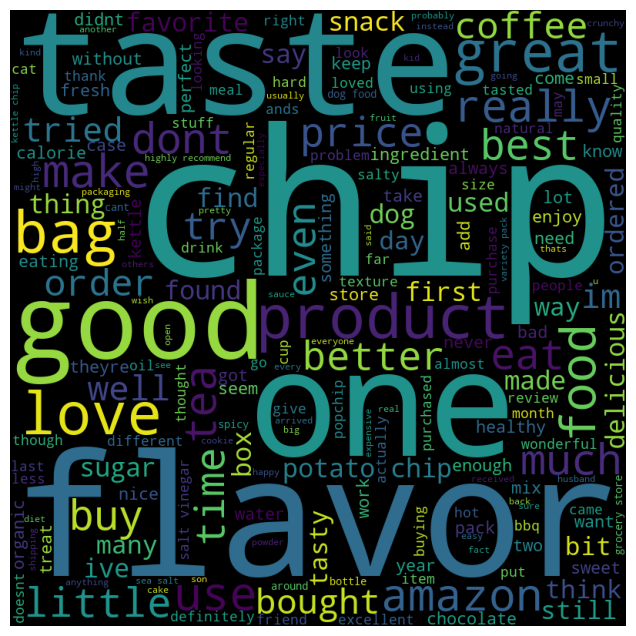

In [85]:
wordcloud = WordCloud(width=800,height=800,stopwords=stopwords).generate(comment_words)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")

In [86]:
data_dd.head(10)

Id   ProductId          UserId                       ProfileName  \
2774  2775  B00002NCJC  A13RRPGE79XFFH                          reader48   
2773  2774  B00002NCJC  A196AJHU9EASJN                      Alex Chaffee   
1243  1244  B00002Z754  A3B8RCEI0FXFI6                         B G Chase   
1244  1245  B00002Z754  A29Z5PI9BW2PU3                            Robbie   
3202  3203  B000084DVR  A3DKGXWUEP1AI2       Glenna E. Bauer "Puppy Mum"   
3203  3204  B000084DVR  A1UGDJP1ZJWVPF      T. Moore "thoughtful reader"   
1160  1161  B000084E1U  A3DH85EYHW4AQH                      Eric Hochman   
2379  2380  B0000CGFV4  A3LSUKN4IFS6VD                     Internet Diva   
2255  2256  B0000DC5IY    AGYZZ3QXV9S8  Dr. Glenn B. Gero "NJnaturaldoc"   
2256  2257  B0000DC5IY   A3GKE33FI1QKA               The Barb Knows Best   

      HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
2774                     0                       0      5  1281052800   
2773                     0                       0      4  1282953600   
1243                    10                      10      5   962236800   
1244                     7                       7      5   961718400   
3202                     3                       3      5  1163030400   
3203                     1                       1      5  1177977600   
1160                     1                       1      5  1140739200   
2379                     0                       0      5  1312416000   
2255                     3                       4      1  1289865600   
2256                     0                       0      1  1322697600   

                                                Summary  Polarity  \
2774                                       Flies Begone    0.0000   
2773                                      thirty bucks?    0.0000   
1243                     WOW Make your own 'slickers' !    0.4250   
1244                                      Great Product    0.8000   
3202                        Premium Quality Dog Food!!!    0.0000   
3203                                        Good stuff!    0.8750   
1160                                      Cats love it!    0.6250   
2379               Nice, Big Pieces & Big Almond Flavor    0.2000   
2255  Don't buy this product unless you are looking ...    0.0000   
2256                                      Little Flavor   -0.1875   

                                              cleantext  
2774  b'used victor fly bait seasons ca beat great p...  
2773  b'product available victor traps unreal course...  
1243  b'received shipment could hardly wait try prod...  
1244  b'really good idea final product outstanding u...  
3202  b'using food months find excellent fact two do...  
3203  b'glad cocker standard poodle puppy loves stuf...  
1160  b'nine cats crazy kibbles last thing want cat ...  
2379  b'shipped day ordered arrived within days live...  
2255  b'description product disceptive product repre...  
2256  b'bought brand online indian grocery store usu...

In [87]:
data_dd=data_dd.drop('Polarity',axis=1)
       

In [88]:
final=data_dd.copy()

In [89]:
def partition(x):
    if x < 3:
        return 0  #denotes negative 
    if x > 3:
        return 1  #denotes positive
    return 2

In [90]:
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = data_dd['Score']
positiveNegative = actualScore.map(partition)
final['Score'] = positiveNegative
test_df = final[final['Score']==2]
final = final[final['Score']!=2]
print("Number of data points in our data", final.shape)
final.head()

Number of data points in our data (4592, 10)


Id   ProductId          UserId                  ProfileName  \
2774  2775  B00002NCJC  A13RRPGE79XFFH                     reader48   
2773  2774  B00002NCJC  A196AJHU9EASJN                 Alex Chaffee   
1243  1244  B00002Z754  A3B8RCEI0FXFI6                    B G Chase   
1244  1245  B00002Z754  A29Z5PI9BW2PU3                       Robbie   
3202  3203  B000084DVR  A3DKGXWUEP1AI2  Glenna E. Bauer "Puppy Mum"   

      HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
2774                     0                       0      1  1281052800   
2773                     0                       0      1  1282953600   
1243                    10                      10      1   962236800   
1244                     7                       7      1   961718400   
3202                     3                       3      1  1163030400   

                             Summary  \
2774                    Flies Begone   
2773                   thirty bucks?   
1243  WOW Make your own 'slickers' !   
1244                   Great Product   
3202     Premium Quality Dog Food!!!   

                                              cleantext  
2774  b'used victor fly bait seasons ca beat great p...  
2773  b'product available victor traps unreal course...  
1243  b'received shipment could hardly wait try prod...  
1244  b'really good idea final product outstanding u...  
3202  b'using food months find excellent fact two do...

In [91]:
y=final["Score"]
x=final.drop(columns='Score')
print(x.shape)

(4592, 9)


In [92]:
#Train test split 
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(x, y,test_size=0.3)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(3214, 9)
(1378, 9)
(3214,)
(1378,)


## Featurization

In [93]:
#BoW on train dataset 
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(train_x["cleantext"])
print('='*50)
final_vector = count_vect.transform(train_x["cleantext"])
print("the type of count vectorizer ",type(final_vector))
print("the shape of out text BOW vectorizer ",final_vector.get_shape())
print("the number of unique words ", final_vector.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (3214, 10797)
the number of unique words  10797


In [94]:
#BoW on test dataset 
final_vec = count_vect.transform(test_x["cleantext"])
print("the type of count vectorizer ",type(final_vec))
print("the shape of out text BOW vectorizer ",final_vec.get_shape())
print("the number of unique words ", final_vec.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (1378, 10797)
the number of unique words  10797


In [95]:
#TF-IDF on train dataset 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(train_x["cleantext"])
print('='*50)

final_tf_idf = tf_idf_vect.transform(train_x["cleantext"])
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (3214, 2010)
the number of unique words including both unigrams and bigrams  2010


In [96]:
#TF-IDF on test dataset 
final_tf_idftest = tf_idf_vect.transform(test_x["cleantext"])
print("the type of count vectorizer ",type(final_tf_idftest))
print("the shape of out text TFIDF vectorizer ",final_tf_idftest.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idftest.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (1378, 2010)
the number of unique words including both unigrams and bigrams  2010


## Modelling

In [97]:
from scipy import sparse
features=train_x[["HelpfulnessNumerator","HelpfulnessDenominator"]].values
train_X=sparse.hstack((features,final_tf_idf))
train_X.shape

(3214, 2012)

In [98]:
#USing synthetic oversampling. for train dataset
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [99]:
x_trains, y_trains = smote.fit_resample(train_X,train_y)
values=y_trains.value_counts()

print(values)

0    2685
1    2685
Name: Score, dtype: int64


Text(0, 0.5, 'Frequency')

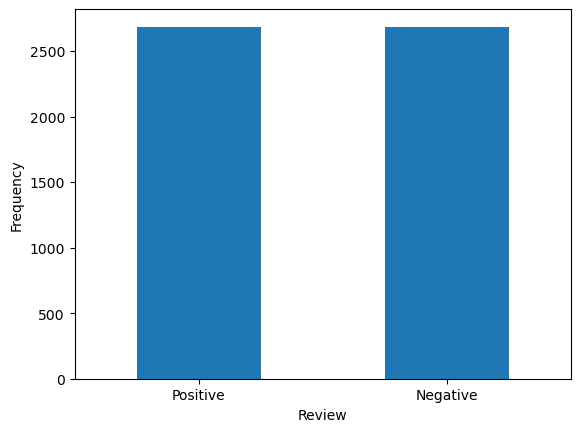

In [100]:
values.plot(kind = 'bar', rot=0)

labels=['Positive','Negative']
plt.xticks(range(2),labels)
plt.xlabel("Review")
plt.ylabel("Frequency")

In [101]:
from scipy import sparse
feature_test=test_x[["HelpfulnessNumerator","HelpfulnessDenominator"]].values
test_X=sparse.hstack((feature_test,final_tf_idftest))
test_X.shape

(1378, 2012)

In [102]:
#USing synthetic oversampling. for test dataset
x_tests,y_tests=smote.fit_resample(test_X,test_y)
values_test=y_tests.value_counts()
print(values_test)


1    1153
0    1153
Name: Score, dtype: int64


## Using Naive Bayes Classification 

In [107]:
from sklearn.naive_bayes import GaussianNB
NBC= GaussianNB()
XN_train=x_trains.todense()
NBC.fit(np.asarray(XN_train),y_trains)

GaussianNB()

In [108]:
predict_yn=NBC.predict(x_tests.toarray()) 

In [109]:
#Accuracy of the model 
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_tests,predict_yn)
accuracy

0.6283607979184735

## Measure of Performance 

In [110]:
conf_matrix = confusion_matrix(y_true=y_tests, y_pred=predict_yn)
conf_matrix

array([[555, 598],
       [259, 894]], dtype=int64)

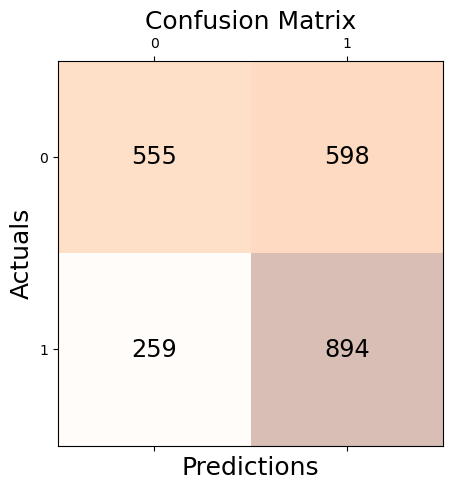

In [111]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [112]:
#Precision of the model 
from sklearn.metrics import precision_score
print('Precision: %.3f' % precision_score(y_tests, predict_yn))

Precision: 0.599


In [113]:
#Recall of the model
from sklearn.metrics import recall_score
print('Recall: %.3f' % recall_score(y_tests, predict_yn))


Recall: 0.775


In [114]:
#True Negative Rate /Specificity 
TNR=conf_matrix[0][0]/((conf_matrix[0][0]+conf_matrix[0][1]))
print("Specificity "+ str(TNR))


Specificity 0.4813529921942758


In [115]:
from sklearn.metrics import roc_curve, roc_auc_score
y_scoren = NBC.predict_proba(x_tests.toarray())[:,1]
false_positive_raten, true_positive_raten, thresholdn = roc_curve(y_tests, y_scoren)
print('roc_auc_score for Naive Bayes Classification: ', roc_auc_score(y_tests, y_scoren))

roc_auc_score for Naive Bayes Classification:  0.6417223743783891


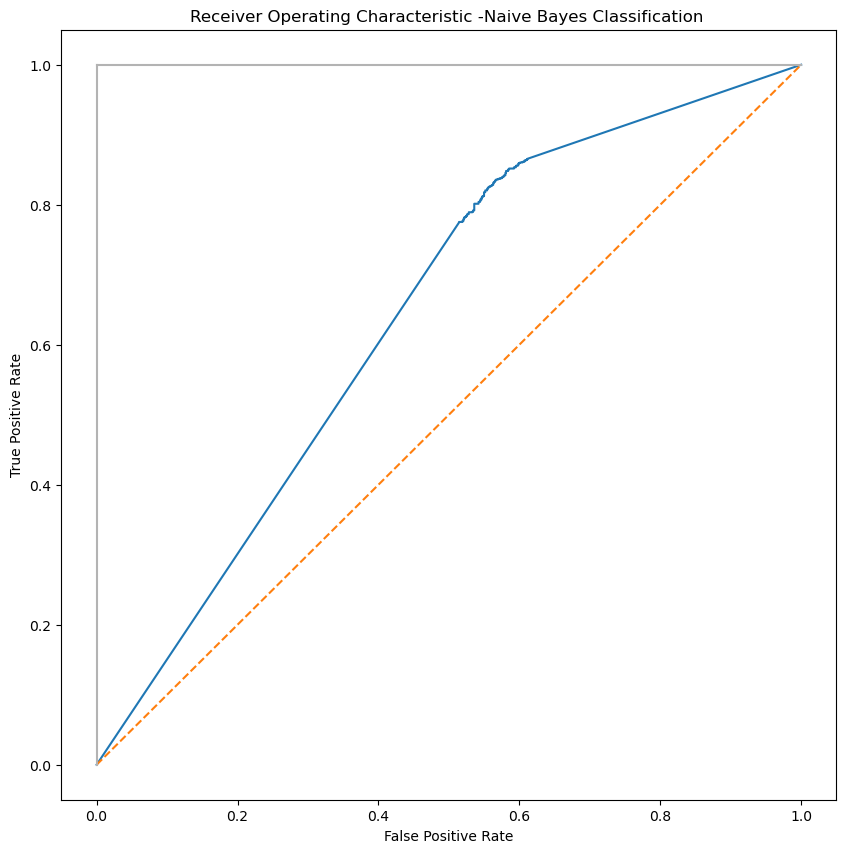

In [116]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic -Naive Bayes Classification ')
plt.plot(false_positive_raten, true_positive_raten)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Logistic Regression 


In [118]:
#Fitting the model 
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(x_trains,y_trains)

LogisticRegression()

In [119]:
predict_y=model.predict(x_tests)  #predicting the class by using logistic classifier

In [120]:
#Accuracy of the model 
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_tests,predict_y)
accuracy

0.8248048568950563

In [121]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
conf_matrix = confusion_matrix(y_true=y_tests, y_pred=predict_y)
conf_matrix

array([[ 848,  305],
       [  99, 1054]], dtype=int64)

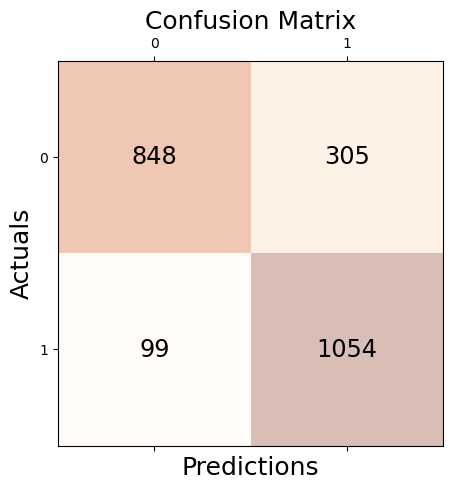

In [122]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [123]:
#Precision of the model 
print('Precision: %.3f' % precision_score(y_tests, predict_y))

Precision: 0.776


In [124]:
#Recall of the model
print('Recall: %.3f' % recall_score(y_tests, predict_y))

Recall: 0.914


In [125]:
#True Negative Rate /Specificity 
TNR=conf_matrix[0][0]/((conf_matrix[0][0]+conf_matrix[0][1]))
print("Specificity "+ str(TNR))


Specificity 0.7354726799653079


In [126]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score = model.predict_proba(x_tests)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_tests, y_score)
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_tests, y_score))

roc_auc_score for Logistic Regression:  0.9320457436349536


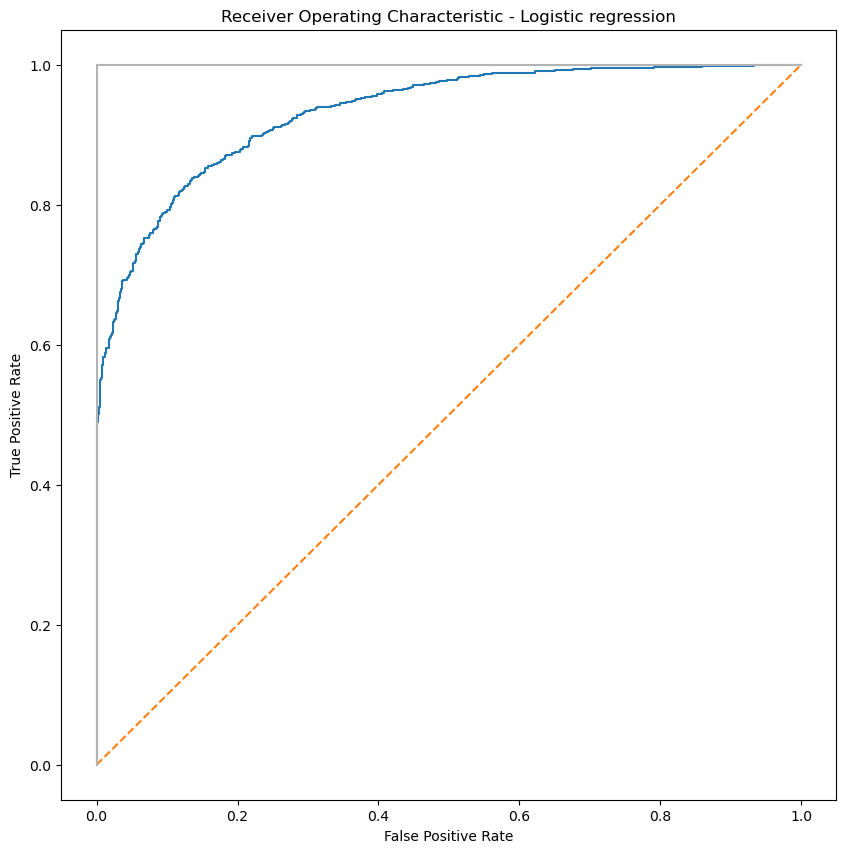

In [127]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [136]:
x_test=test_df.drop(columns=['Score'])

In [138]:
final_vec_test = tf_idf_vect.transform(x_test["cleantext"])

In [143]:
features=x_test[["HelpfulnessNumerator","HelpfulnessDenominator"]].values
x_test_sparse=sparse.hstack((feature_test,final_tf_idftest))

## Predicting the polarity of the reviews with rating = 3

In [145]:
y_pred=model.predict(x_test_sparse)

In [161]:
y_pred = np.where(y_pred == 1, 'positive', 'negative')
unique_values, counts = np.unique(y_pred, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: negative, Count: 261
Value: positive, Count: 1117
